In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [3]:
%ls

 Balanced_I_hotel_dataset_final.ipynb     LSTM_stop_final_lstm_ablation.ipynb
 Balanced_II_hotel_dataset_final.ipynb    optuna_test/
 booking_time_final_original/             output/
 Business_hotel_dataset_final.ipynb       output_other_dataset/
 clustered_test.pkl                       Preprocess_data_dunnhumby.ipynb
 copy_optuna_test/                        Preprocess_data_full_hotel_dataset_final.ipynb
 data_analysis/                           price_tft/
 Leisure_hotel_dataset_final.ipynb        RandomForestRegressor_final_dunnhumby.ipynb
 lightning_logs/                          RandomForestRegressor_final.ipynb
 LSTM_final_dunnhumby_FINAL.ipynb        'Readme file.gdoc'
 LSTM_next_final_ablation.ipynb           TFT_creation_to_creation_final.ipynb
 LSTM_next_final.ipynb                    tft.pkl
 LSTM_next_final_no_lstm_ablation.ipynb   TFT_target_price_final.ipynb
 LSTM_stop_final_ablation.ipynb           Trained_models/
 LSTM_stop_final.ipynb                    Transformer_enc

imported libraries

In [4]:
!pip install pytorch_forecasting
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_exten

In [5]:

import os
import pandas as pd
from datetime import date, timedelta, datetime
import numpy as np
import lightning.pytorch as pl

import math
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

import matplotlib.pyplot as plt


To ignore warnings:

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
df_all_hotels_remv = pd.read_feather('output/10_selected_guest_data/df_all_hotels_remv_updated_withminus1000_dif_clus')

In [8]:
dictionary_guests = dict(zip(df_all_hotels_remv["guest_id"], df_all_hotels_remv["hotel_name"]))

In [9]:
df_all_hotels_remv = df_all_hotels_remv.drop(["level_0", "index", "state", "birthday", "reservation_id", "arrival", "departure", "booking_channel", "hotel_name"], axis = 1)
df_all_hotels_remv = df_all_hotels_remv.set_index(["guest_id", "time_index"])

In [10]:
dates = pd.date_range(start=df_all_hotels_remv["creation_date"].dt.date.min(), end= df_all_hotels_remv["creation_date"].dt.date.max())
lst_values = list(range(1, len(dates) + 1))
dict_dates = {dates[i]: lst_values[i] for i in range(len(dates))}

In [11]:
df_all_hotels_remv["time_index_with_creation_date"] = df_all_hotels_remv["creation_date"].dt.date.map(dict_dates)
df_all_hotels_remv = df_all_hotels_remv.drop(["creation_date"], axis = 1)

In [12]:
df_copy = df_all_hotels_remv.copy()

In [13]:
df_copy = df_copy[df_copy["creation_to_new_creation"] != -1000]

In [14]:
df_grouped = df_copy.groupby("guest_id").mean()

In [15]:
df_grouped.loc[df_grouped['creation_to_new_creation'].between(0, 500, 'both'), 'bin'] = 1
# df_grouped.loc[df_grouped['creation_to_new_creation'].between(300, 500, 'right'), 'bin'] = 2
df_grouped.loc[df_grouped['creation_to_new_creation'].between(500, 600, 'right'), 'bin'] = 2
df_grouped.loc[df_grouped['creation_to_new_creation'].between(600, 700, 'right'), 'bin'] = 3
df_grouped.loc[df_grouped['creation_to_new_creation'].between(700, 800, 'right'), 'bin'] = 4
df_grouped.loc[df_grouped['creation_to_new_creation'].between(800, 900, 'right'), 'bin'] = 5
df_grouped.loc[df_grouped['creation_to_new_creation'].between(900, 1000, 'right'), 'bin'] = 6
df_grouped.loc[df_grouped['creation_to_new_creation'].between(1000, 1100, 'right'), 'bin'] = 7

In [16]:
df_grouped_sample = df_grouped.sample(frac=1).groupby('bin', sort=False).head(5800)
guests = df_grouped_sample.index
df_balanced = df_all_hotels_remv.loc[guests]
# df_balanced = df_balanced.drop(columns = ["time_index_with_creation_date"])

In [17]:
df_statistics = df_balanced.copy()
df_statistics["hotel"] = df_balanced.index.get_level_values(0).map(dictionary_guests)

In [18]:
grouped_df = df_statistics.groupby("guest_id").mean()
grouped_df["amount_times_visited"].describe()

count    16337.000000
mean         2.796291
std          1.659236
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: amount_times_visited, dtype: float64

In [19]:
X = df_balanced.drop(["creation_to_new_creation", "group_type", "vacation_type"], axis = 1)
y = df_balanced["creation_to_new_creation"]

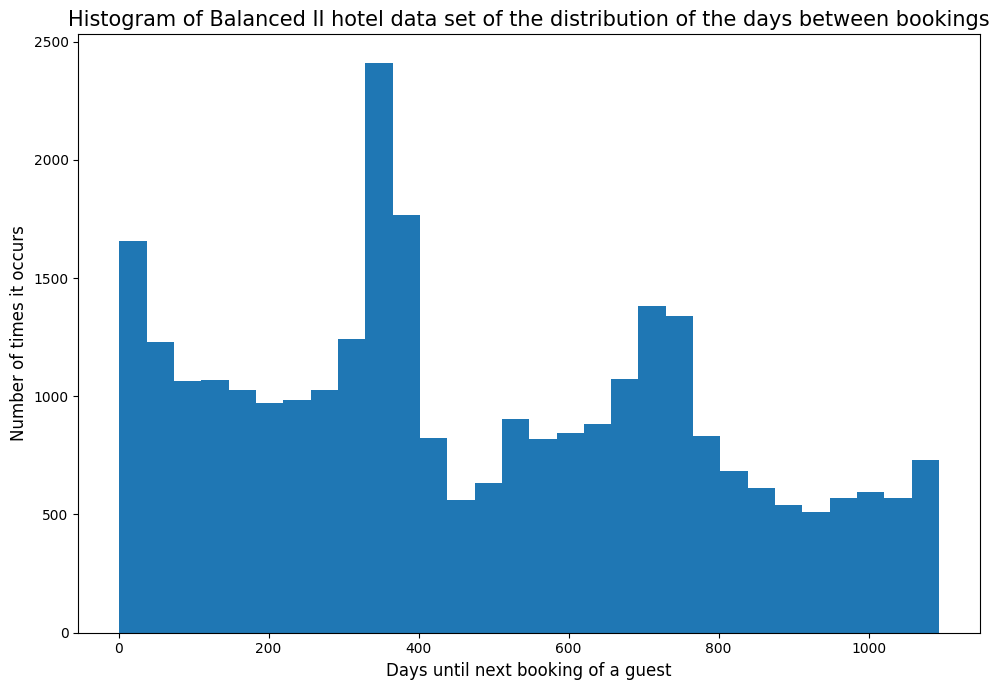

In [20]:
y_without_1000 = y[y > 0]
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)

axs.hist(y_without_1000, bins = 30)
plt.title("Histogram of Balanced II hotel data set of the distribution of the days between bookings", size = 15)
plt.xlabel("Days until next booking of a guest", size = 12)
plt.ylabel("Number of times it occurs", size = 12)
# Show plot
plt.show()

In [ ]:
y.to_csv('output/10_selected_guest_data/y_balancedII_data')

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output/10_selected_guest_data/df_balancedII_data')

In [ ]:
scaler = RobustScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output/10_selected_guest_data/df_balancedII_data_robustscaler')

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output/10_selected_guest_data/df_balancedII_data_standardscaler')